# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

In [1]:
from IPython.display import display, HTML   
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

### Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

In [3]:
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# # load the train dataset

# X={}
# Y=[]


# if os.path.isfile('./X.pkl') and os.path.isfile('./Y.pkl'):
#     X = pickle.load(open('./X.pkl','rb'))
#     Y = pickle.load(open('./Y.pkl','rb'))

#     val_data_tensor = pickle.load(open('./val_data_tensor.pkl','rb'))
#     val_label_tensor = pickle.load(open('./val_label_tensor.pkl','rb'))
#     te_data_tensor = pickle.load(open('./te_data_tensor.pkl','rb'))
#     te_label_tensor = pickle.load(open('./te_label_tensor.pkl','rb'))

#     total_tr_len = 50000

# else:
#     train_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#         ])

#     cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

#     cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)

#     total_tr_len = len(cifar10_train)
#     total_test_len = len(cifar10_test)


#     for i in range(len(cifar10_train)):
#         data = cifar10_train[i][0].numpy()
#         label = cifar10_train[i][1]
        
#         if label not in Y:
#             Y.append(label)
#             X[label] = []

#         X[label].append(data)

#     for label in Y:
#         X[label] = np.array(X[label])

#     # testing and validation set-up
#     X_TV = []
#     Y_TV = []

#     for i in range(len(cifar10_test)): 
#         X_TV.append(cifar10_train[i][0].numpy())
#         Y_TV.append(cifar10_train[i][1])

#     val_data = X_TV[0:5000]    
#     val_label = Y_TV[0:5000] 

#     te_data = X_TV[5000:]    
#     te_label = Y_TV[5000:] 


#     val_data_tensor=torch.from_numpy(np.array(val_data)).type(torch.FloatTensor)
#     val_label_tensor=torch.from_numpy(np.array(val_label)).type(torch.LongTensor)

#     te_data_tensor=torch.from_numpy(np.array(te_data)).type(torch.FloatTensor)
#     te_label_tensor=torch.from_numpy(np.array(te_label)).type(torch.LongTensor)

        
#     pickle.dump(X,open('./X.pkl','wb'))
#     pickle.dump(Y,open('./Y.pkl','wb'))
#     pickle.dump(val_data_tensor,open('./val_data_tensor.pkl','wb'))
#     pickle.dump(val_label_tensor,open('./val_label_tensor.pkl','wb'))
#     pickle.dump(te_data_tensor,open('./te_data_tensor.pkl','wb'))
#     pickle.dump(te_label_tensor,open('./te_label_tensor.pkl','wb'))


# for i in range(len(cifar10_test)):
#     X.append(cifar10_test[i][0].numpy())
#     Y.append(cifar10_test[i][1])

# user_tr_data_tensors=[]
# user_tr_label_tensors=[]

# alpha = 20
# n_class = 10

# nusers=50
# user_tr_len= total_tr_len // nusers
# val_len=5000
# te_len=5000

# for i in range(nusers):
#     alpha_list = [alpha for _ in range(n_class)]
#     probs = np.random.dirichlet(alpha_list)
    
#     user_tr_data_tensor=[]
#     user_tr_label_tensor=[]

#     for j in range(n_class):
#         n_pair = math.ceil(probs[j] * user_tr_len)

#         random_indices = np.random.choice(len(X[j]), n_pair, replace=False)
#         user_tr_data_tensor.extend(X[j][random_indices])
#         user_tr_label_tensor.extend([j] * n_pair)

#     user_tr_data_tensor = torch.from_numpy(np.array(user_tr_data_tensor[0:1000])).type(torch.FloatTensor)
#     user_tr_label_tensor = torch.from_numpy(np.array(user_tr_label_tensor[0:1000])).type(torch.FloatTensor)

#     user_tr_data_tensors.append(user_tr_data_tensor)
#     user_tr_label_tensors.append(user_tr_label_tensor)
#     print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

### Divide cifar10 data among 50 clients in IID fashion using Dirichlet distribution

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)

X=[]
Y=[]
for i in range(len(cifar10_train)):
    X.append(cifar10_train[i][0].numpy())
    Y.append(cifar10_train[i][1])

for i in range(len(cifar10_test)):
    X.append(cifar10_test[i][0].numpy())
    Y.append(cifar10_test[i][1])

X=np.array(X)
Y=np.array(Y)

print('total data len: ',len(X))


all_indices = np.arange(len(X))
np.random.shuffle(all_indices)
pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))


X=X[all_indices]
Y=Y[all_indices]

# data loading

nusers=50
user_tr_len=1000

total_tr_len=user_tr_len*nusers
val_len=5000
te_len=5000

print('total data len: ',len(X))

if not os.path.isfile('./cifar10_shuffle.pkl'):
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))
else:
    all_indices=pickle.load(open('./cifar10_shuffle.pkl','rb'))

total_tr_data=X[:total_tr_len]
total_tr_label=Y[:total_tr_len]

val_data=X[total_tr_len:(total_tr_len+val_len)]
val_label=Y[total_tr_len:(total_tr_len+val_len)]

te_data=X[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]
te_label=Y[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]

total_tr_data_tensor=torch.from_numpy(total_tr_data).type(torch.FloatTensor)
total_tr_label_tensor=torch.from_numpy(total_tr_label).type(torch.LongTensor)

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

print('total tr len %d | val len %d | test len %d'%(len(total_tr_data_tensor),len(val_data_tensor),len(te_data_tensor)))

#==============================================================================================================

user_tr_data_tensors=[]
user_tr_label_tensors=[]

for i in range(nusers):
    
    user_tr_data_tensor=torch.from_numpy(total_tr_data[user_tr_len*i:user_tr_len*(i+1)]).type(torch.FloatTensor)
    user_tr_label_tensor=torch.from_numpy(total_tr_label[user_tr_len*i:user_tr_len*(i+1)]).type(torch.LongTensor)

    user_tr_data_tensors.append(user_tr_data_tensor)
    user_tr_label_tensors.append(user_tr_label_tensor)
    print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

Files already downloaded and verified
Files already downloaded and verified
total data len:  60000
total data len:  60000
total tr len 50000 | val len 5000 | test len 5000
user 0 tr len 1000
user 1 tr len 1000
user 2 tr len 1000
user 3 tr len 1000
user 4 tr len 1000
user 5 tr len 1000
user 6 tr len 1000
user 7 tr len 1000
user 8 tr len 1000
user 9 tr len 1000
user 10 tr len 1000
user 11 tr len 1000
user 12 tr len 1000
user 13 tr len 1000
user 14 tr len 1000
user 15 tr len 1000
user 16 tr len 1000
user 17 tr len 1000
user 18 tr len 1000
user 19 tr len 1000
user 20 tr len 1000
user 21 tr len 1000
user 22 tr len 1000
user 23 tr len 1000
user 24 tr len 1000
user 25 tr len 1000
user 26 tr len 1000
user 27 tr len 1000
user 28 tr len 1000
user 29 tr len 1000
user 30 tr len 1000
user 31 tr len 1000
user 32 tr len 1000
user 33 tr len 1000
user 34 tr len 1000
user 35 tr len 1000
user 36 tr len 1000
user 37 tr len 1000
user 38 tr len 1000
user 39 tr len 1000
user 40 tr len 1000
user 41 tr len 100

## Code for Multi-krum aggregation algorithm

In [5]:
def multi_krum(all_updates, n_attackers, multi_k=False):
    print("all_updates.shape: ", all_updates.shape)
    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    print("candidates", len(candidates))

    aggregate = torch.mean(candidates, dim=0)

    return aggregate, np.array(candidate_indices)

## Code for Bulyan aggregation algorithm

In [6]:
def bulyan(all_updates, n_attackers):
    nusers = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (nusers - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## Code for our AGR-tailored attack on Bulyan
* Note that our attacks on multi-krum and Bulyan aggregations are the same

In [7]:
def our_attack_mkrum(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)

    lamda = torch.Tensor([3.0]).cuda()

    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        mal_updates = torch.stack([mal_update] * n_attackers)
        # print("mal_updates1: ",mal_updates.shape)
        mal_updates = torch.cat((mal_updates, all_updates), 0)
        # print("mal_updates12: ",mal_updates.shape)
        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=True)
        if np.sum(krum_candidate < n_attackers) == n_attackers:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)
    # print(mal_update.shape)
    return mal_update

## our_attack_mean_std
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}| + \lambda_2 |\bar{\sigma_{mean\ benige\ users}} - \bar{\sigma_{attacker(s)}}|)$

In [8]:
def our_attack_mean_std(all_updates, model_re, n_attacker, arch, criterion, user_tr_data_tensors, user_tr_label_tensors):
    
    all_updates_deviation = all_updates.std(dim=1, keepdim=True) # [50, 1]
    benign_std_avg = all_updates_deviation.mean() # [1, 1]

    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = [] 
    attacker_grads = all_updates[:n_attacker]


    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_tr_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_tr_label_tensors[index].cuda()

        def rosen(X):
            X = X.cuda()
            attacker_abs_mean = X.abs().mean()
            attacker_std = X.abs().std()

        #     # Reshape X into the shape of fed_model.parameters
            fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
            optimizer_fed = SGD(fed_model.parameters(), lr=0.5)

            optimizer_fed.zero_grad()
            model_grads=[]
            start_idx = 0
            for i, param in enumerate(fed_model.parameters()):
                param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            optimizer_fed.step(model_grads)

            return -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor) + torch.abs(benign_std_avg - attacker_abs_mean) + torch.abs(benign_abs_mean_avg - attacker_std)
        
        from torchmin import minimize

        res = minimize(
            rosen, attacker_grad, 
            method='l-bfgs', 
            options=dict(line_search='strong-wolfe'),
            max_iter=100,
            disp=False
        )
        result_attacker_grads.append(res.grad)
        # if result_attacker_grads is None:
        #     result_attacker_grads = res.grad
        # else:
        #     result_attacker_grads.append(res.grad)

    return torch.stack(result_attacker_grads).cuda()

## Execute our AGR-tailored attack on Bulyan

In [40]:
batch_size=250
resume=0

nepochs=100
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(nusers): # 50

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                # print(param.shape)
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            agg_grads = torch.mean(user_grads[:n_attacker], 0)

            # No attack
            # malicious_grads = user_grads

            # Attack
            mal_updates = our_attack_mean_std(user_grads, agg_grads, n_attacker, arch, criterion, user_tr_data_tensors, user_tr_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
            

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        # Store history of malicious_grads
        average_tensor = malicious_grads.mean(dim=1, keepdim=True)
        median_tensor = malicious_grads.median(dim=1, keepdim=True).values
        lower_quartile = malicious_grads.quantile(0.25, dim=1, keepdim=True)
        upper_quartile = malicious_grads.quantile(0.75, dim=1, keepdim=True)
        std = malicious_grads.std(dim=1, keepdim=True)

        mean_abs_tensor = malicious_grads.abs().sum(dim=1, keepdim=True)

        past_abs_sum.append(mean_abs_tensor)
        past_mean.append(average_tensor)
        past_median.append(median_tensor)
        past_lower_quartile.append(lower_quartile)
        past_upper_quartile.append(upper_quartile)
        past_std.append(std)


        pickle.dump(past_abs_sum,open('./past_abs_sum.pkl','wb'))
        pickle.dump(past_mean,open('./past_mean.pkl','wb'))
        pickle.dump(past_median,open('./past_median.pkl','wb'))
        pickle.dump(past_lower_quartile,open('./past_lower_quartile.pkl','wb'))
        pickle.dump(past_upper_quartile,open('./past_upper_quartile.pkl','wb'))
        pickle.dump(past_std,open('./past_std.pkl','wb'))

        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 10 n_mal_sel 10 e 0 | val loss 2.3031 val acc 10.2273 best val_acc 10.227273


C:\Users\Hizan\AppData\Local\Temp\ipykernel_14196\3425158245.py:154: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 10 n_mal_sel 10 e 1 | val loss 2.3029 val acc 10.2273 best val_acc 10.227273
epoch: 2, bulyan: at our-agr n_at 10 n_mal_sel 9 e 2 | val loss 2.3027 val acc 10.2273 best val_acc 10.227273
epoch: 3, bulyan: at our-agr n_at 10 n_mal_sel 10 e 3 | val loss 2.3024 val acc 10.2273 best val_acc 10.227273
epoch: 4, bulyan: at our-agr n_at 10 n_mal_sel 10 e 4 | val loss 2.3022 val acc 10.2273 best val_acc 10.227273
epoch: 5, bulyan: at our-agr n_at 10 n_mal_sel 10 e 5 | val loss 2.3020 val acc 10.2273 best val_acc 10.227273
epoch: 6, bulyan: at our-agr n_at 10 n_mal_sel 10 e 6 | val loss 2.3018 val acc 10.2273 best val_acc 10.227273
epoch: 7, bulyan: at our-agr n_at 10 n_mal_sel 10 e 7 | val loss 2.3016 val acc 10.2273 best val_acc 10.227273
epoch: 8, bulyan: at our-agr n_at 10 n_mal_sel 10 e 8 | val loss 2.3013 val acc 10.2273 best val_acc 10.227273
epoch: 9, bulyan: at our-agr n_at 10 n_mal_sel 10 e 9 | val loss 2.3011 val acc 10.2273 best val_acc 10.227273
ep

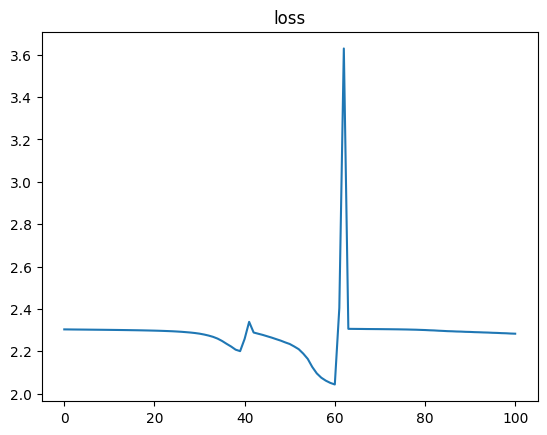

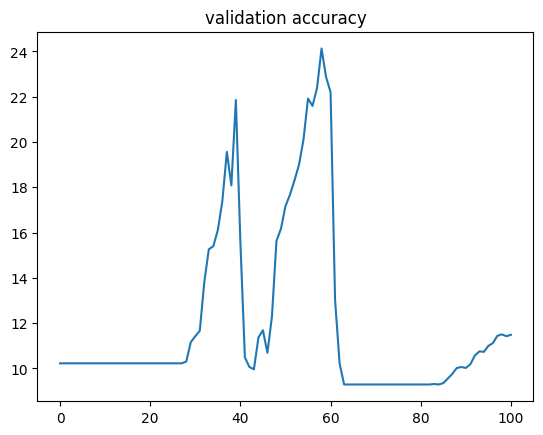

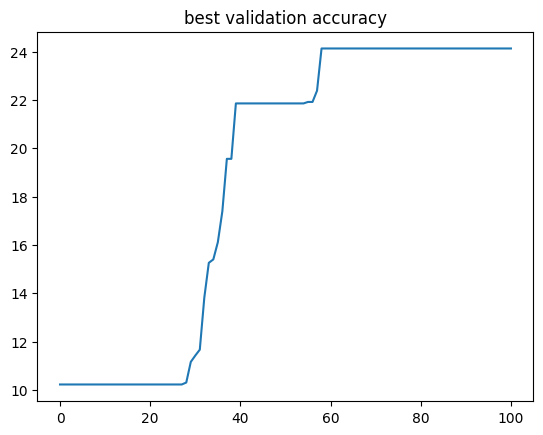

In [41]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title(col)
    plt.savefig('./has_attack_' + col + '.png')
    plt.show()

In [ ]:
# past_mean = []
# past_abs_sum = []
# past_median = []
# past_lower_quartile = []
# past_upper_quartile = []
# past_std = []

print(past_abs_sum[0])